## Load data

In [2]:
import pandas as pd

tm = pd.read_csv("../data/processed/arsenal_team_match_stats.csv")
pm = pd.read_csv("../data/processed/arsenal_player_match_stats.csv")
ars_sched = pd.read_csv("../data/processed/arsenal_schedule.csv")

tm["goal_diff"] = tm["GF"] - tm["GA"]

## Prepare schedule mapping

In [24]:
# re is Python's regular expression module, we will use it later to extract a match identifier from a URL
import re

# Standardising the columns
ars_sched.columns = [c.strip().lower().replace(" ", "_") for c in ars_sched.columns]
# Converting date column into a real datetime type since CSVs read dates as strings by default
ars_sched["date"] = pd.to_datetime(ars_sched["date"])

# Defining helper function to parse the score. e.g. score of 2-1 becomes (2, 1)
def parse_score(score):
    s = str(score).replace("–", "-")
    if "-" not in s:
        return (None, None)
    a, b = s.split("-", 1)
    try:
        return int(a.strip()), int(b.strip())
    except:
        return (None, None)

# Applying the parse function to every row. hg_ag = (home_goals, away_goals)
hg_ag = ars_sched["score"].apply(parse_score)
# Split the tuples into two new columns 
ars_sched["home_goals"] = [x[0] for x in hg_ag]
ars_sched["away_goals"] = [x[1] for x in hg_ag]

# Determining whether Arsenal played home or away
ars_sched["venue"] = ars_sched["home_team"].astype(str).str.strip().apply(
    lambda x: "Home" if x == "Arsenal" else "Away"
)
# Creating Arsenal-centric opponent columns. If Arsenal is home, opponent is away, if Arsenal are away, opponent is home
ars_sched["opponent"] = ars_sched.apply(
    lambda r: r["away_team"] if r["venue"] == "Home" else r["home_team"],
    axis=1
)
# Arsenal-centric goals for. If Arsenal is home, Arsenal scored home goals, if Arsenal are away, they scored away goals
ars_sched["gf"] = ars_sched.apply(
    lambda r: r["home_goals"] if r["venue"] == "Home" else r["away_goals"],
    axis=1
)
# Arsenal-centric away goals. If Arsenal are home, opponent scored away goals, if Arsenal are away, opponent scored home goals
ars_sched["ga"] = ars_sched.apply(
    lambda r: r["away_goals"] if r["venue"] == "Home" else r["home_goals"],
    axis=1
)

# Build a stable match identifier (game_id) from the match report URL
if "game_id" not in ars_sched.columns and "match_report" in ars_sched.columns:
    def extract_game_id(url):
        m = re.search(r"/matches/([^/]+)/", str(url))
        return m.group(1) if m else None
    ars_sched["game_id"] = ars_sched["match_report"].apply(extract_game_id)

ars_sched[["date", "venue", "opponent", "gf", "ga", "game_id"]].head()


,date,venue,opponent,gf,ga,game_id
0,2016-08-14,Home,Liverpool,3,4,0e815975
1,2016-08-20,Away,Leicester City,0,0,7dcbb8b3
2,2016-08-27,Away,Watford,3,1,b123da8c
3,2016-09-10,Home,Southampton,2,1,a8053d4d
4,2016-09-17,Away,Hull City,4,1,f2805e6a


**re expression**

**Code for the regex:** r"/matches/([^/]+/"

- Looks for /matches/
- Then captures ([^/]+), one or more characters that are not a slash until the next /
- e.g. for a URL https://fbref.com/en/matches/abcd1234/Arsenal-Chelsea... it extracts abcd1234 which then becomes game_id
- The if statement ensures we do not overwrite an existing game_id and we only do it if match report exists

## Merge game_id into team match table

In [25]:
tm_clean = tm.copy()
tm_clean["date"] = pd.to_datetime(tm_clean["date"])
tm_clean["venue"] = tm_clean["venue"].astype(str).str.strip().str.title()

# Building a clean schedule mapping including columns needed for the merge and removing duplicates
sched_map = ars_sched[["date", "venue", "opponent", "gf", "ga", "game_id"]].drop_duplicates()

# Merging team stats with the schedule map
tm_with_id = tm_clean.merge(
    sched_map,
    left_on=["date", "venue", "opponent", "GF", "GA"],
    right_on=["date", "venue", "opponent", "gf", "ga"],
    how="left"
)

tm_with_id["game_id"].isna().sum()


np.int64(0)

**team stats merge with schedule map**
- how="left" -> left join
- Keep all rows from tm_clean
- Attach game_id where a match is found
- If no match -> game_id = NaN

## Build player minutes feature matrix

In [6]:
# Pivot player minutes
player_minutes = pm.pivot_table(
    index="game_id",
    columns="player",
    values="min",
    aggfunc="sum",
    fill_value=0
)

player_minutes.shape


(304, 80)

**pm.pivot_table(...)**

A pivot table:
- Groups data
- Reshapes it
- Aggregrates values

For each match (game_id), create one column per player, and fill each cell with the total minutes that player played in that match

**index="game_id"**

- This defines the rows of the output table
- Each row = one match

So the resulting DataFrame has:
- Index -> Unique game_ids
- One row per Arsenal match

**columns="player"**
Each column = One player

e.g 
Bukayo Saka
Declan Rice

If a player never appears in a match, they still get a column

**values="min"**
How many minutes did this player play in this match?

**aggfunc="sum"**

- To ensure total minutes are correct
- No accidental duplication breaks

**fill_values=0**

- No apprearance = 0 minutes
- If player was unvailable/benched/injured

In [7]:
# Join match-level features
match_features = tm_with_id.set_index("game_id")[["goal_diff", "venue"]]

model_df = match_features.join(player_minutes, how="inner")

model_df.shape


(304, 82)

**match_features**
- Makes game_id the row index
- Each row corresponds to one unique match
- game_id becomes the join key
- ["goal_diff", "venue"] only columns selected at this stage

**model_df**
- Joins on the index by default
- Since both tables are indexed by game_id, this is equivalent to "match rows where the game_id exists in both tables"
- **how="inner":** Keeps only matches that exist in match_features and have player-minute data and AVOIDS matches with missing player data and partial rows with NaNs. Bascially we train on matches where we know who played

In [8]:
# Encode home vs away
model_df["is_home"] = (model_df["venue"].str.lower() == "home").astype(int)
model_df = model_df.drop(columns=["venue"])


- Converting venue column which is a string that contains "home" and "away" into boolean series of "True" if home and "False" if away
- .astype(int): True -> 1 and False -> 0
- We then remove the original venue text column

In [9]:
# Define X and y
y = model_df["goal_diff"]
X = model_df.drop(columns=["goal_diff"])

X.shape, y.shape


((304, 81), (304,))

**Target variable (y)**
- Extracts goal_diff column from model_df
- Stores it in a separate variable y
- Each value in y is "goals scored by Arsenal - goals conceded"
- This is our dependent variable, the thing the model is trying to predict


**Feature Matrix (X)**
- Takes everything except the target variable y
- Leaves only explanatory variables
- X contains is_home and player-minute columns

**Why this separation matters**
- X -> inputs
- y -> outputs



- Each coefficient means **"Holding everything else constant, an extra minute played by player X is associated with a delta in goal difference"**

We will not be training our data just yet, we will:
- Standardise features
- Apply **Ridge** and **Lasso** regression
- Validate stability
- Rank players by impact

# Modelling: Which Arsenal players actually drive wins?

Our x matrix has:
- Many correlated features
- More features than matches
- Strong multicollinearity

So,
- Ordinary Least Squares (OLS) is unstable
- Ridge and Lasso regression are the right tools

## Train/Test split

In [10]:
# Sort by date and split
from sklearn.model_selection import train_test_split

# Ensure chronological order
model_df_sorted = model_df.sort_index()

X = model_df_sorted.drop(columns=["goal_diff"])
y = model_df_sorted["goal_diff"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

X_train.shape, X_test.shape

((243, 81), (61, 81))

**sklearn and importing train_test split**
This imports scikit-learn's standard function for splitting data into:
- training set
- testing set

We will use it to evaluate how well our model generalises

**model_df_sorted**
- Our index is game_id, which our pipeline is aligned with match order
- Sorting ensures matches are in chronological order
- Essentially this means earlier matches first, later matches last

**X_train, X_test, y_train, y_test**
- Test size 0.2 means 20% of matches go to the test set
- 80% of matches go to training
- shuffle=False, we turned off shuffle because football is time-ordered e.g. squad evolves, form changes, tactics change etc, so shuffling would leak future information into the past

## Standardise features

In [11]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Importing StandardScaler**
- Imports StandardScaler from scikit-learn
- This tool standardises numerical features so they're on the same scale

**scaler = StandardScaler()**
- Creates an unfitted scaler
- At this point it knows nothing about our data and no means or standard deviations have been computed


**fit(...)**
When you call fit on X_train, the scaler computes:
- Mean of each feature (column)
- Standard Deviation of each feature

**transform(...)**
- Mean becomes 0
- Standard Deviation becomes 1
- This ensures all features are on comparable scales and large-minute players do not dominate small-minute ones

**Without Scaling:**
- A player with large-minute values (0-90) gets penalised more
- A binary feature (is_home) gets penalised less
- Coefficients become incomparable and biased

**With Scaling:**
- All coefficients are treated fairly
- Regularisation behaves correctly
- Player impact is interpretable
 

---------------------------------

- Ensures coefficients are comparable
- Required for Ridge/Lasso
- Prevents minutes-heavy players from dominating purely due to scale

## Ridge Regression (baseline model)

In [12]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)


,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


Ridge handles:
- Multicollinearity
- Shared minutes
- Squad overlap

Ridge is:
- a regularised linear regression model
- still linear (like OLS) but with penalty that reduces overfitting and stabilises coefficients when features are correlated

**alpha:** alpha=1.0 controls the strength of regularisation
- alpha = 0 -> OLS (no penalty)
- small alpha -> weak regularisation
- large alpha -> strong shrinkage toward zero
- we have selected a moderate default value



## Evaluate Ridge performance

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = ridge.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

rmse, r2



(np.float64(2.010045809993781), -0.3907398106323674)

**Root Mean Squared Error (RMSE):** How wrong are my predictions, in goals?
**R^2:** How much of the variation am I explaining?

**y_pred:** Generating predictions on unseen data. Uses untrained Ridge model and applies it to test data only. Each value in y_pred is the model's predicted goal difference for that match

**Interpreting RSME:** 2.01 means on average our model's prediction is 2 goals off

**Interpreting R^2**
- R^2 = 1.0 -> perfect predictions
- R^2 = 0.0 -> no better than predicting the mean
- R^2 < 0 -> worse than the baseline


No issues if R^2 is low, since football outcomes are noisy, interpretation matters more than predictions

## Interpret player impact

In [15]:
# Extract coefficients
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": ridge.coef_
})

coef_df = coef_df.sort_values("coef", ascending=False)
coef_df.head(15)


,feature,coef
78,William Saliba,1.010264
31,Granit Xhaka,0.972352
72,Shkodran Mustafi,0.958278
56,Nacho Monreal,0.774531
39,Kai Havertz,0.750719
68,Rob Holding,0.630821
35,Jakub Kiwior,0.466078
16,David Luiz,0.394334
28,Gabriel Magalhães,0.387198
54,Mohamed Elneny,0.382126


- **Positive** coefficient -> associated with better goal difference
- **Negative** coefficient -> associated with worse outcomes
- **Magnitude** -> relative impact per standardised minute

In [17]:
# Separate players from controls
player_coefs = coef_df[~coef_df["feature"].isin(["is_home"])]


### Top positive impact players

In [19]:
player_coefs.head(10)


,feature,coef
78,William Saliba,1.010264
31,Granit Xhaka,0.972352
72,Shkodran Mustafi,0.958278
56,Nacho Monreal,0.774531
39,Kai Havertz,0.750719
68,Rob Holding,0.630821
35,Jakub Kiwior,0.466078
16,David Luiz,0.394334
28,Gabriel Magalhães,0.387198
54,Mohamed Elneny,0.382126


### Most negative impact players

In [20]:
player_coefs.tail(10)


,feature,coef
0,Aaron Ramsdale,-0.084207
49,Mathew Ryan,-0.087995
15,Danny Welbeck,-0.102090
63,Petr Čech,-0.114142
10,Bukayo Saka,-0.156189
6,Alexandre Lacazette,-0.159668
32,Henrikh Mkhitaryan,-0.171413
36,Joe Willock,-0.200830
3,Albert Sambi Lokonga,-0.201839
76,Theo Walcott,-0.513931


## Lasso Regression (feature selection)

In [21]:
# Fit Lasso
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.05)
lasso.fit(X_train_scaled, y_train)


,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.05
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=1000The maximum number of iterations.",1000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


**Ridge vs Lasso**

**Ridge**
- How much should each feature contribute, assuming all features matter a bit?
- Keeps all players
- Shrinks everyone toward zero

**Lasso**
- Which features matter at all?
- Drops weak players entirely
- Produces a sparse model
- Identifies a core subset of players
- Reduce noise

In [22]:
# Inspect non-zero coefficients
lasso_coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": lasso.coef_
})

important_players = lasso_coef_df[lasso_coef_df["coef"] != 0]
important_players.sort_values("coef", ascending=False).head(15)


,feature,coef
31,Granit Xhaka,0.357599
80,is_home,0.283285
78,William Saliba,0.265643
39,Kai Havertz,0.255001
20,Denis Suárez,0.228270
54,Mohamed Elneny,0.189027
57,Nathan Butler-Oyedeji,0.156437
35,Jakub Kiwior,0.143899
66,Reiss Nelson,0.140210
72,Shkodran Mustafi,0.129989


**lasso_coef_df:** Pairing each feature name with its Lasso coefficient

**important_players**
- Selects only rows where coef <> 0
- Drops all features Lasso decided were unnecessary
- Sorts from most positive to most negative impact

In [23]:
# Sanity check: Are top players also heavy-minute players?
minutes_total = pm.groupby("player")["min"].sum().reset_index()
minutes_total.columns = ["player", "total_minutes"]

player_coefs.merge(minutes_total, left_on="feature", right_on="player", how="left") \
            .sort_values("coef", ascending=False).head(10)


,feature,coef,player,total_minutes
0,William Saliba,1.010264,William Saliba,8874
1,Granit Xhaka,0.972352,Granit Xhaka,16342
2,Shkodran Mustafi,0.958278,Shkodran Mustafi,8412
3,Nacho Monreal,0.774531,Nacho Monreal,7527
4,Kai Havertz,0.750719,Kai Havertz,4509
5,Rob Holding,0.630821,Rob Holding,6144
6,Jakub Kiwior,0.466078,Jakub Kiwior,2495
7,David Luiz,0.394334,David Luiz,4205
8,Gabriel Magalhães,0.387198,Gabriel Magalhães,10812
9,Mohamed Elneny,0.382126,Mohamed Elneny,3625


In [27]:
minutes_total = pm.groupby("player")["min"].sum()

eligible_players = minutes_total[minutes_total >= 900].index  # 10 full matches

player_coefs_filtered = player_coefs[player_coefs["feature"].isin(eligible_players)]
player_coefs_filtered.head(10)


,feature,coef
78,William Saliba,1.010264
31,Granit Xhaka,0.972352
72,Shkodran Mustafi,0.958278
56,Nacho Monreal,0.774531
39,Kai Havertz,0.750719
68,Rob Holding,0.630821
35,Jakub Kiwior,0.466078
16,David Luiz,0.394334
28,Gabriel Magalhães,0.387198
54,Mohamed Elneny,0.382126


- Players appearing in both Ridge top rankings and Lasso selection are the most robust impact contributors

In [28]:
ridge_full = Ridge(alpha=1.0)
ridge_full.fit(scaler.fit_transform(X), y)

coef_full = pd.Series(ridge_full.coef_, index=X.columns)

coef_compare = pd.DataFrame({
    "train_only": coef_df.set_index("feature")["coef"],
    "full_data": coef_full
})

coef_compare.corr()


,train_only,full_data
train_only,1.000000,0.944562
full_data,0.944562,1.000000


In [31]:
# --- Robustness: Ridge vs Lasso overlap ---

# Ridge coefficients dataframe (if you already created it, reuse it)
coef_df = pd.DataFrame({"feature": X.columns, "coef": ridge.coef_}).sort_values("coef", ascending=False)

player_coefs = coef_df[coef_df["feature"] != "is_home"].copy()

# Lasso non-zero (if you already created important_players, reuse it)
lasso_coef_df = pd.DataFrame({"feature": X.columns, "coef": lasso.coef_})
important_players = lasso_coef_df[(lasso_coef_df["feature"] != "is_home") & (lasso_coef_df["coef"] != 0)].copy()

ridge_top = set(player_coefs.head(15)["feature"])
lasso_nonzero = set(important_players["feature"])
robust_players = sorted(list(ridge_top & lasso_nonzero))

pd.DataFrame({"robust_players_ridge∩lasso": robust_players})

,robust_players_ridge∩lasso
0,Granit Xhaka
1,Jakub Kiwior
2,Kai Havertz
3,Konstantinos Mavropanos
4,Martin Ødegaard
5,Mohamed Elneny
6,Nacho Monreal
7,Santi Cazorla
8,Shkodran Mustafi
9,William Saliba


In [32]:
# --- Minimum minutes threshold ---

minutes_total = pm.groupby("player")["min"].sum().sort_values(ascending=False)
min_minutes = 900  # ~10 full matches
eligible_players = set(minutes_total[minutes_total >= min_minutes].index)

player_coefs_filt = player_coefs[player_coefs["feature"].isin(eligible_players)].copy()

player_coefs_filt.head(10), player_coefs_filt.tail(10)

(              feature      coef
 78     William Saliba  1.010264
 31       Granit Xhaka  0.972352
 72   Shkodran Mustafi  0.958278
 56      Nacho Monreal  0.774531
 39        Kai Havertz  0.750719
 68        Rob Holding  0.630821
 35       Jakub Kiwior  0.466078
 16         David Luiz  0.394334
 28  Gabriel Magalhães  0.387198
 54     Mohamed Elneny  0.382126,
                 feature      coef
 60       Olivier Giroud -0.040735
 55   Myles Lewis-Skelly -0.068769
 0        Aaron Ramsdale -0.084207
 15        Danny Welbeck -0.102090
 63            Petr Čech -0.114142
 10          Bukayo Saka -0.156189
 6   Alexandre Lacazette -0.159668
 32   Henrikh Mkhitaryan -0.171413
 36          Joe Willock -0.200830
 76         Theo Walcott -0.513931)

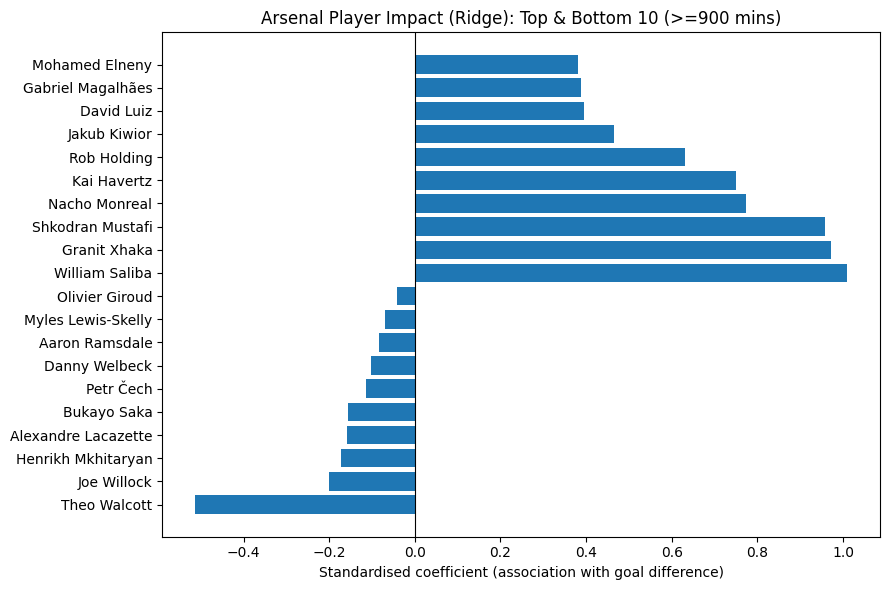

In [33]:
import matplotlib.pyplot as plt
from pathlib import Path

Path("../reports/figures").mkdir(parents=True, exist_ok=True)

top10 = player_coefs_filt.sort_values("coef", ascending=False).head(10)
bot10 = player_coefs_filt.sort_values("coef", ascending=True).head(10)
top_bottom = pd.concat([bot10, top10])  # bottom first for nicer plot

plt.figure(figsize=(9,6))
plt.barh(top_bottom["feature"], top_bottom["coef"])
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Arsenal Player Impact (Ridge): Top & Bottom 10 (>=900 mins)")
plt.xlabel("Standardised coefficient (association with goal difference)")
plt.tight_layout()
plt.savefig("../reports/figures/impact_top_bottom_ridge.png", dpi=200)
plt.show()


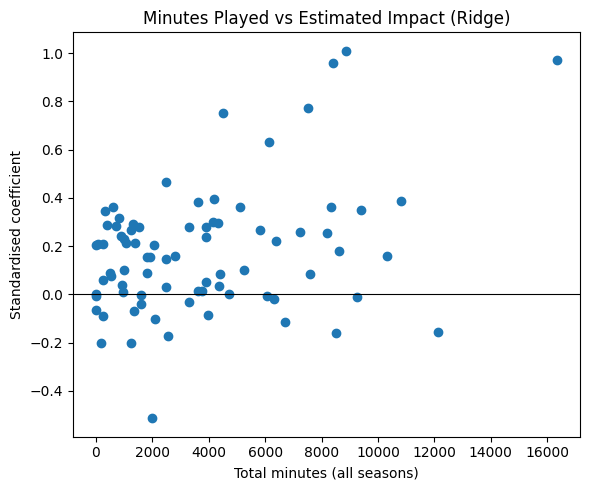

In [34]:
impact_minutes = player_coefs.merge(
    minutes_total.reset_index(),
    left_on="feature",
    right_on="player",
    how="left"
).rename(columns={"min": "total_minutes"})

plt.figure(figsize=(6,5))
plt.scatter(impact_minutes["total_minutes"], impact_minutes["coef"])
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Minutes Played vs Estimated Impact (Ridge)")
plt.xlabel("Total minutes (all seasons)")
plt.ylabel("Standardised coefficient")
plt.tight_layout()
plt.savefig("../reports/figures/minutes_vs_impact.png", dpi=200)
plt.show()


**Interpretation (Analysis 1)**

This model estimates associations between player minutes and Arsenal match goal difference (not causal effects).

Ridge stabilises coefficients in the presence of multicollinearity (players frequently play together).

Lasso provides a sparse shortlist of players with non-zero estimated impact.

Results are interpreted primarily for players with ≥900 total minutes to reduce small-sample noise.


**Limitations**

Coefficients are context-dependent (tactics, teammates, opponents, manager).

Football outcomes are noisy; predictive metrics (R^2) are not the primary objective.

Estimates represent an average across seasons.

In [35]:
from pathlib import Path

Path("../reports/figures").mkdir(parents=True, exist_ok=True)

In [36]:
plt.savefig("../reports/figures/impact_top_bottom_ridge.png", dpi=200)
plt.show()


<Figure size 640x480 with 0 Axes>

In [37]:
plt.savefig("../reports/figures/minutes_vs_impact.png", dpi=200)
plt.show()


<Figure size 640x480 with 0 Axes>